In [1]:
import numpy as np
import matplotlib.pyplot as plt

## PHYS 481 Assignment 5

November 22, 2018

Kenneth Sharman (00300185)

### Introduction

BLAH BLAH BLAH

A one-dimensional wave can be modelled by the differential equation
$$ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} $$
Suppose that we have the initial conditions,
$$ u(x,0) = A \sin \Big( \frac{\pi}{L}mx \Big) \qquad x \in [0,L]$$
$$ \frac{\partial}{\partial t} u(x,0) = 0 \qquad x \in [0,L] $$
and that the medium in which the wave in propagating is stationary at the endpoints
$$ u(0,t) = 0 \qquad \text{and} \qquad u(L,t) = 0 \qquad t \in (0,T] $$
The solution to this differential equation is
$$ u_e(x,t) = A \sin \Big(  \frac{\pi}{L}mx \Big) \cos \Big(  \frac{\pi}{L}mct \Big) $$

#### Discretizing the Domain
Both the temporal domain $[0,T]$ and the spatial domain $[0,L]$ can represented by a finite number of mesh points, and implemented using numpy arrays. A two-dimensional meshgrid can be defined using these arrays.

The second-order derivatives in the wave equation can be replaced by the following difference equations
$$ \frac{\partial^2}{dt^2} u(x_i,t_n) \approx \frac{{u_i}^{n+1} - 2 {u_i}^n + {u_i}^{n-1} }{\Delta t^2} $$
$$ \frac{\partial^2}{\partial x^2}u(x_i,t_n) \approx \frac{{u_{i+1}}^n -2 {u_i}^n + {u_{i-1}}^n }{\Delta x^2} $$
The wave equation can therefore be written as a finite difference equation with the form
$$ \frac{{u_i}^{n+1} - 2 {u_i}^n + {u_i}^{n-1} }{\Delta t^2} = c^2 \frac{{u_{i+1}}^n -2 {u_i}^n + {u_{i-1}}^n }{\Delta x^2} $$
Note that this equation will only be satisfied in the interior points of the two-dimensional domain since the nearest neighbors of the previous generation are required.
Expressing the second intial condition in terms of a finite difference equation gives
$$ \frac{\partial}{\partial t} u(x_i,0) \approx \frac{{u_i}^{1} - {u_i}^{-1}}{2 \Delta t} $$
and the other initial condition imposes the condition
$$ {u_i}^0 = A\sin\Big( \frac{\pi}{L} m x_i \Big) \qquad i=0,\dots,N_x $$

#### Formulating the recursive algorithm
Assume that ${u_i}^n$ and ${u_i}^{n-1}$ are known for $i=0,\dots,N_x$. We must solve for ${u_i}^{n+1}$ by rearranging the finite difference equation
$$ {u_i}^{n+1} = -{u_i}^{n-1} + 2{u_i}^{n} + C^2 ({u_{i+1}}^{n} -2{u_i}^{n} + {u_{i-1}}^{n} ) \qquad [1]$$
where the parameter $C$ is known as the $\textit{Courant number}$
$$ C = c \frac{\Delta t}{\Delta x} $$

If we wish to begin this recursive algorithm at ${u_i}^{2}$ the above equation tells us that we need both ${u_i}^{0}$ and ${u_i}^{1}$. The initial conditions give the former and the latter can be determined by combining the initial conditions with equation 1.
$$ {u_i}^{1} = {u_i}^{0} + \frac{1}{2} C^2 ({u_{i+1}}^{0} -2{u_i}^{0} + {u_{i-1}}^{0} ) $$


### Question 1: Explain wavelength and period for $\sin(kx)\cos(\omega t)$

For a sine wave of the form $\sin(kx)$ we usually think of $k=\frac{2\pi}{T}$ where $T$ is the period. However, in this case the wave is a function of distance. This means that instead of a period we refer to the wavelength $\lambda$, hence $$k=\frac{2\pi}{\lambda} \qquad \Longrightarrow \qquad \lambda = \frac{2\pi}{k}$$
The wavelength is the spatial period of a periodic wave and represents the distance over which the wave's shape repeats [1].

For a cosine wave of the form $\cos(\omega t)$ we do have a temporal period, which we will denote as $P$.
$$ \omega = \frac{2\pi}{P} \qquad \Longrightarrow \qquad P = \frac{2\pi}{\omega} $$

The analytic solution to the above differential equation is
$$ u_e(x,t) = A\sin\Big( \frac{\pi}{L}mx \Big) \cos\Big( \frac{\pi}{L}mct \Big) $$
Using the above work to determine the wavelength
$$ k = \frac{\pi m}{L} \qquad \Longrightarrow \qquad \lambda = \frac{2L}{m} $$
and the period
$$ \omega = \frac{\pi m c}{L} \qquad \Longrightarrow \qquad P = \frac{2L}{mc} $$
Knowning these values with help us with the analysis in this report.

In [2]:
class OneDWave:
    def __init__(self, L, T, A, m, c):
        self.L, self.T = L, T
        self.x, self.t = np.linspace(0, L, 100), np.linspace(0, T, 100)
        self.Nx, self.Nt = len(self.x)-1, len(self.t)-1
        self.dx, self.dt = self.x[1]-self.x[0], self.t[1]-self.t[0]
        self.A, self.m, self.c, self.C2 = A, m, c, (c*self.dt/self.dx)**2
        self.__init__generations()
    
    def initial_cond(self, x):
        return self.A * np.sin((np.pi/self.L)*self.m*x)
    
    def calc_analytic_soln(self, time=0):
        self.analytic = self.A*np.sin((np.pi/self.L)*self.m*self.x) \
            *np.cos((np.pi/self.L)*self.m*self.c*time)
    
    def __init__generations(self):
        self.u, self.u_n, self.u_nm1 = np.zeros(len(self.x)), np.zeros(len(self.x)), np.zeros(len(self.x))
        self.u_n = self.initial_cond(self.x[:])
        self.u[1:-1] = self.u_n[1:-1] + 0.5*self.C2*(self.u_n[2:]-2*self.u_n[1:-1]+self.u_n[:-2])
        self.u_nm1[:], self.u_n[:] = self.u_n, self.u
        self.calc_analytic_soln(time=0)
        
    def update_u(self):
        # Update all inner mesh points at time t[n+1]
        self.u[1:-1] = -self.u_nm1[1:-1] + 2*self.u_n[1:-1] \
        + self.C2*(self.u_n[2:]-2*self.u_n[1:-1]+self.u_n[:-2])
        self.u_nm1[:], self.u_n[:] = self.u_n, self.u
        
    def step(self, plot=False):
        if plot==True:
            plt.figure(figsize=(15, 10)) # Set the plot size
            plt.plot(self.x, self.u_nm1, label='first')
            for n in range(1, self.Nt):
                self.update_u()
                if n%5==0:
                    plt.plot(self.x, self.u, label=n)
            plt.legend()
        else:
            for n in range(1, self.Nt):
                self.update_u()
        self.calc_analytic_soln(time=self.T)


Befre we implement this class, it is a good idea to run a test. We expect that by using the initial conditions, the wave at $t_0 = 0$ will be equal to the analytical solution at $t=0$. Let's run at test with relatively low tolerance to verify this is the case. 

In [3]:
def test_class1DWave():
    '''
    Test class asserts that u_nm1(t=0) is within 1e-16 of the analytic solution
    '''
    test_wave = OneDWave(L=50,T=100,A=1e-6,m=16,c=2) # Assign random numbers
    assert np.abs(max(test_wave.u_nm1-test_wave.analytic)) < 1e-16, 'Wave not initialize properly'
    
test_class1DWave()

$L = 18 \qquad m=4 \qquad c = 1$
$$P = \frac{2L}{mc} = \frac{2(18)}{4(1)} = 9$$

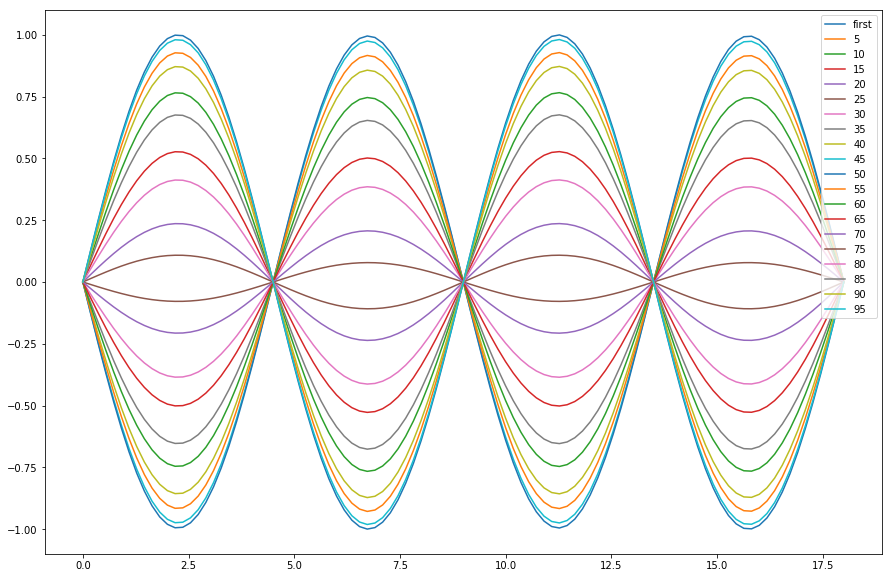

In [4]:
wave = OneDWave(L=18,T=9,A=1,m=4,c=1)
wave.step(plot=True)

### Question 2: Make plot for the numerical/ exact solutions and for the error 

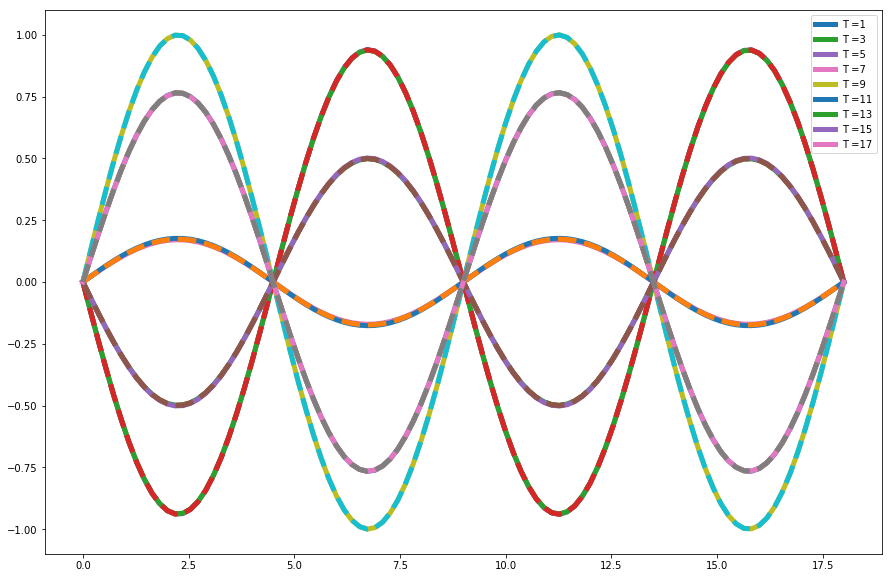

In [11]:
T_vals = np.arange(1,19,2)
#T_vals = np.arange(1,20,2)

plt.figure(figsize=(15, 10)) # Set the plot size
for t in T_vals:
    wave = OneDWave(L=18,T=t,A=1,m=4,c=1)
    wave.step()
    plt.plot(wave.x, wave.u, lw=5, label='T ='+str(t))
    plt.plot(wave.x, wave.analytic, ls='--', lw=5)
plt.legend()
plt.show()

### References

[1] - https://en.wikipedia.org/wiki/Wavelength